# Determinação de parâmetros de exoplanetas por ajuste do trânsito pelo algoritmo MCMC

_Por meio da análise da curva de luz de estrelas com trânsitos de exoplanetas e realizando um ajuste dos dados pelo modelo ECLIPSE utilizando o algoritmo MCMC (Markov Chain Monte Carlo) presente neste código, é possível descobrir com maior precisão os parâmetros reais do exoplaneta e sua órbita. O programa foi otimizado para que seu tempo de execução fosse reduzido drasticamente._

In [1]:
from Adjust.Model import Modelo
from Adjust.Treatment import Tratamento
from Adjust.Adjust import Ajuste, AjusteManchado
from Misc.Verify import converte, calculaLat
from Star.Estrela import Estrela
from Planet.Eclipse import Eclipse
from Planet.Planeta import Planeta
import numpy
import matplotlib.pyplot as plt
import corner

In [2]:
def plotLegendAdjust(plot, mission): 
    # Adicionando título e legendas dos eixos
    plot.title(f'Curva de luz extraída do Telescópio { mission } x Curva de luz ajustada')
    plot.xlabel('Eixo X (Tempo)')
    plot.ylabel('Eixo Y (Brilho da estrela)')

    # Exibindo a legenda
    plot.legend()
    plot.show()

def plotLegendModel(ax, mission): 
 # Adicionando título e legendas dos eixos
    ax.set_title(f'Curva de luz extraída do Telescópio { mission }  x Curva de luz modelo')
    ax.set_xlabel('Eixo X (Tempo)')
    ax.set_ylabel('Eixo Y (Brilho da estrela)')

    # Exibindo a legenda
    ax.legend()
    plt.show()

# Entrada Estrela e Eclipse

_A Estrela e o Eclipse serão criados através de classes auxiliares presentes nos arquivos ```eclipse.py``` e ```estrela.py```. A classe Estrela constrói a matriz que representa a estrela, enquanto a classe Eclipse calcula a curva de luz daquela estrela dado parâmetros planetários imputados. Cada planeta também pode conter uma lua em sua órbita, dessa forma, cada eclipse pode possuir uma ou mais luas, através da classe Moon. 
Os parâmetros de criação da estrela e eclipse, juntamente com a(s) lua(s) estão presentes no bloco abaixo._

In [9]:
# -------------- Parâmetros de entrada --------------
# --------------------- Estrela ---------------------
# https://exoplanet.eu/catalog/kepler_468_b--3539/
mission = "Kepler"
star_name = 'Kepler-468'
cadence = 'short'
raio = 373. #default (pixel)
rsun = 0.870 # raio da estrela em Rsun
intensidadeMaxima = 240 #default
tamanhoMatriz = 856 #default 
u1 = 0.365
u2 = 0.080
star_temp = 5498.0 #em Kelvin


# --------------------- Planeta HD189733-A ---------------------
raio_plan_Jup = 1.308
semi_eixo_UA = 0.226
angulo_inclinacao = 90.60 #em graus
periodo = 38.477 # day
mass_planeta = 0.96 #em relacao a M de jupiter
lua = False 
ecc = 0
anomalia = 0

#etapa de conversão
#raioStar, raioPlanetaRstar , semiEixoRaioStar = converte(rsun, raio_plan_Jup, semi_eixo_UA)

### Construção da Estrela e do Eclipse
_Após a construção da matriz estrela e do eclipse calculado, temos a resultante da curva de luz representada graficamente abaixo._

1.1376917362213135


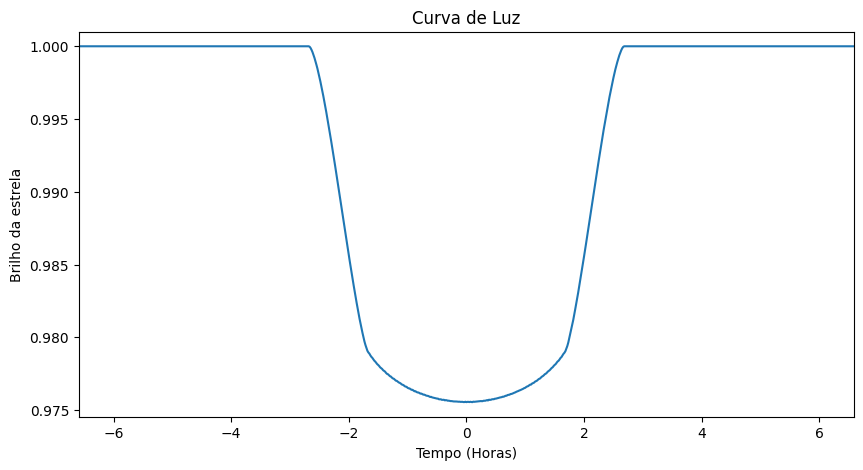

In [14]:
estrela_ = Estrela(raio, rsun, intensidadeMaxima, u1, u2, tamanhoMatriz)

Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()

planeta_ = Planeta(semi_eixo_UA, raio_plan_Jup, periodo, angulo_inclinacao, ecc, anomalia, estrela_.getRaioSun(), mass_planeta)

eclipse = Eclipse(Nx, Ny, raioEstrelaPixel, estrela_, planeta_)
estrela_.setStarName(star_name)
estrela_.setCadence(cadence)
eclipse.setTempoHoras(1.)

eclipse.criarEclipse(anim=False)
lc0 = numpy.array(eclipse.getCurvaLuz()) 
ts0 = numpy.array(eclipse.getTempoHoras())

### Criar um modelo através do Eclipse 
_Um modelo será criado através da base de curva de luz construída para que o algorimo seja aplicado_

In [11]:
modelo = Modelo(estrela_, eclipse, mission)

ls_model, ts_model = modelo.eclipse_model()

time, flux, flux_err = modelo.rd_data(0, 0)

modelo.setTime(time)
modelo.setFlux(flux)
modelo.setFluxErr(flux_err)

x0, nt = modelo.det_x0(0)

print("Numero de trânsitos ::::",nt)

Numero de trânsitos :::: 26.0


### Tratamendo do modelo 
_Nesta etapa o trânsito será cortado para que seja analisada apenas a etapa onde há variância na curva de luz. A classe ```Modelo``` coleta os dados do telescópio (Kepler ou Tess) obtidos através do ```método de trânsito``` e como esses dados apresentam muitos resíduos, a etapa de tratamento faz-se necessária._

In [12]:
tratamento = Tratamento(modelo)

dur, tim, lcurve, f_err = tratamento.cut_transit_single()

# t_p = tim[25]
# s_lc = lcurve[25]

# bb = numpy.where((t_p >= min(ts0)) & (t_p <= max(ts0)))
# bb = numpy.where((ts0 >= -5.) & (ts0 <= 5.))
# dd = numpy.where((t_p >= -5.) & (t_p <= 5.))

### Visualizando todos os trânsitos
_Rodar bloco abaixo apenas se desejar visualizar todos os trânsitos_

porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477
porb 38.477


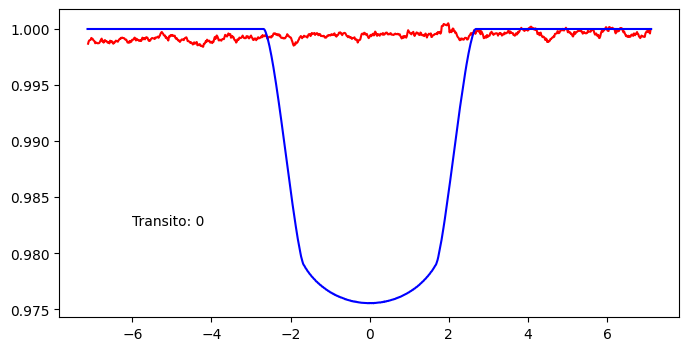

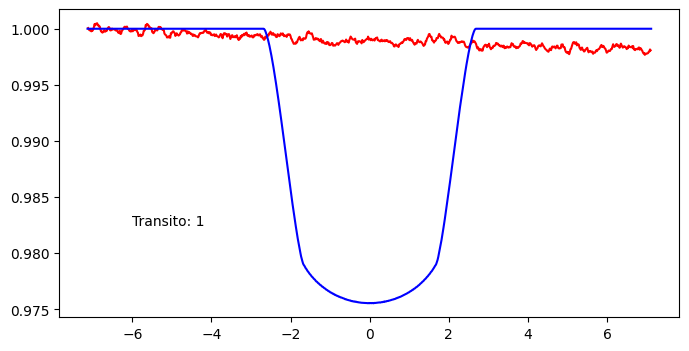

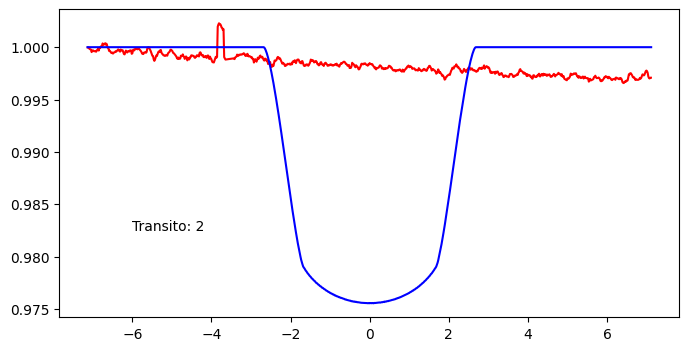

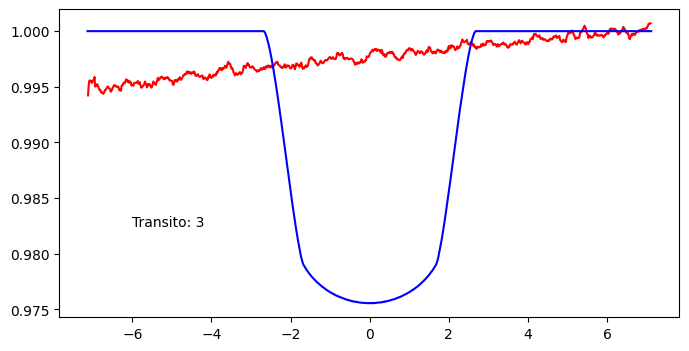

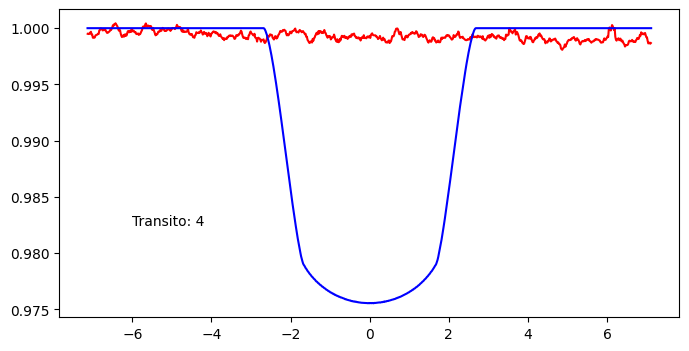

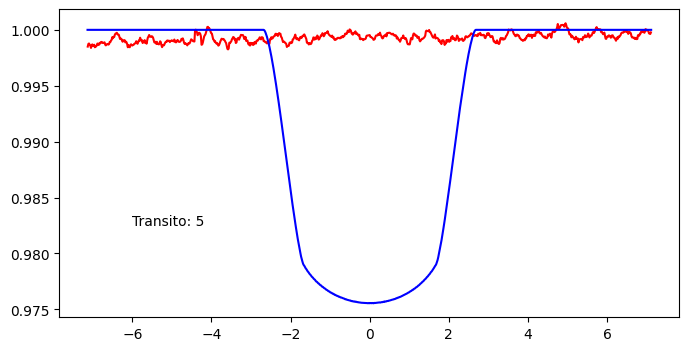

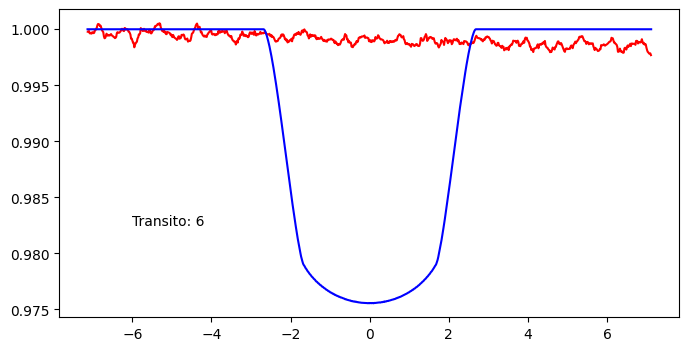

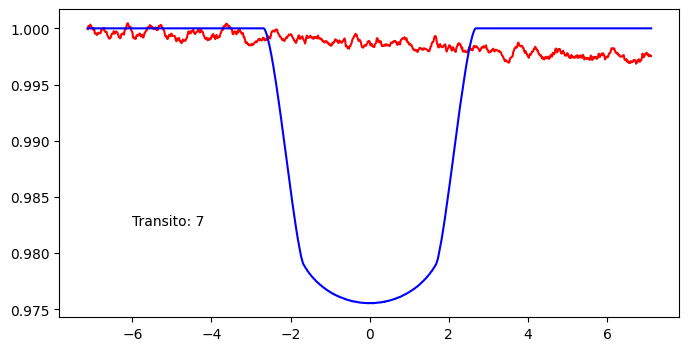

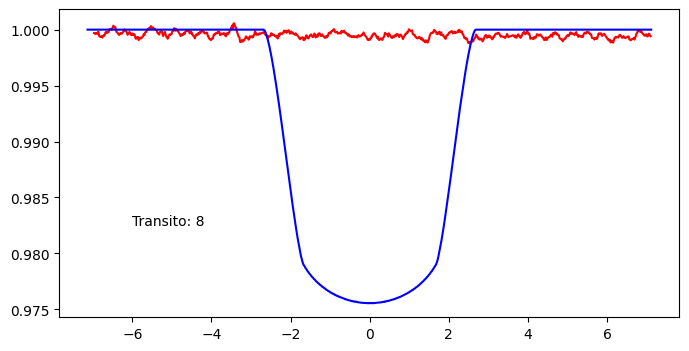

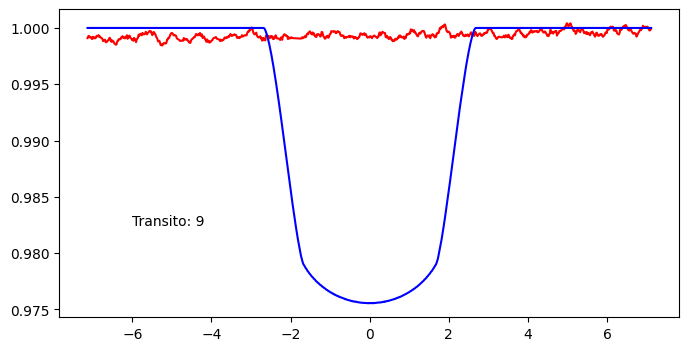

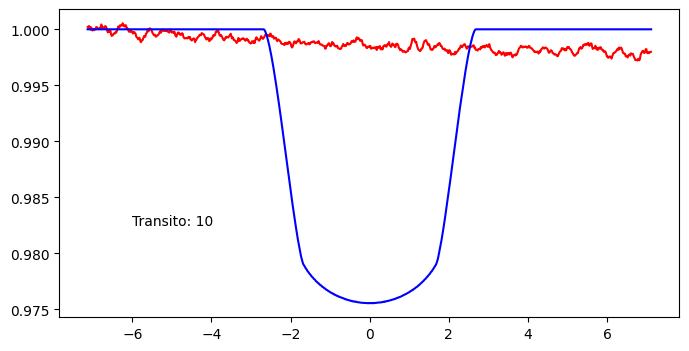

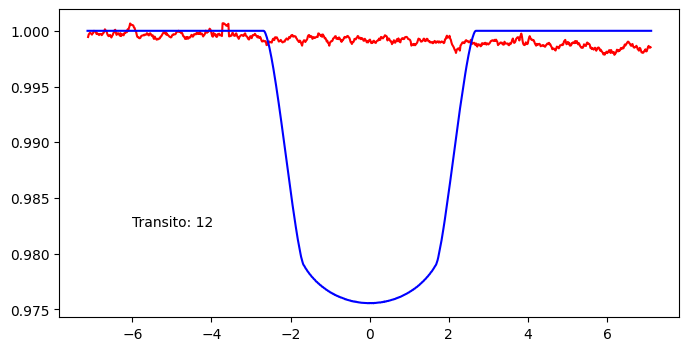

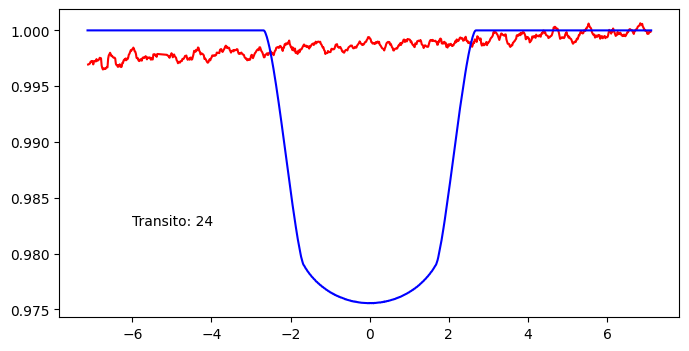

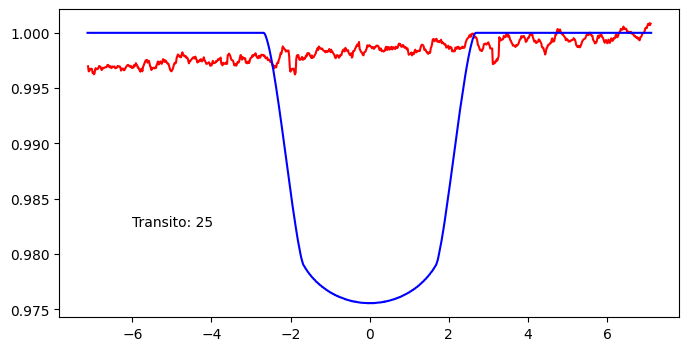

In [13]:
for i in range(int(nt)):
    try:
        selectedTransit = i #transito selecionado
        time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)
        media = sum(sorted(smoothed_LC, reverse=True)[:100]) / 100
        smoothed_LC = smoothed_LC / media

        plt.rcParams['figure.figsize']= 8,4
        graf1,ax = plt.subplots()

        ax.plot(time_phased, smoothed_LC, "r", ms = 2)
        ax.plot(ts_model, ls_model, "b", ms = 2)
        ax.annotate(f"Transito: {i}", (-6, 0.9825))
        
    except:
        pass


### Curvas de luz resultantes 
_Abaixo, temos representadas a curva de luz inicial com a curva de luz obtida através dos dados inputados pelo telescópio (```LightKurve```) após o tratamento. É utilizada a curva de luz inicial para a comparação da curva de luz obtida através do telescópio._

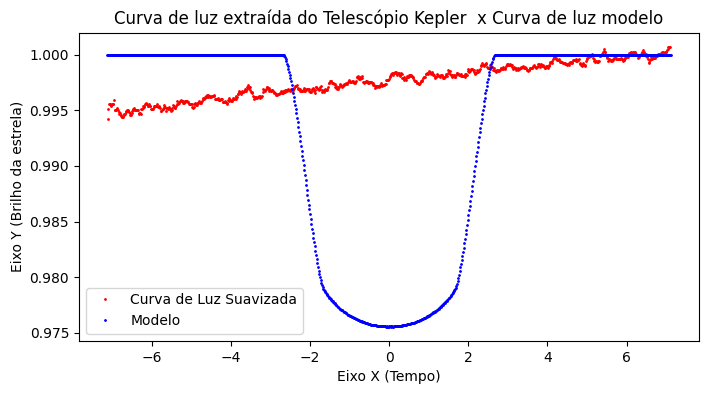

In [33]:
# COM ESCOLHA DE TRÂNSITO
selectedTransit = 3 #transito selecionado

time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)
media = sum(sorted(smoothed_LC, reverse=True)[:100]) / 100
smoothed_LC = smoothed_LC / media

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()

ax.plot(time_phased, smoothed_LC, "r.", ms=2, label='Curva de Luz Suavizada')
ax.plot(ts_model, ls_model, "b.", ms=2, label='Modelo')


plotLegendModel(ax, mission)


# 📝 MCMC
_Ajustes realizados para a aplicação do algoritmo MCMC. As variáveis ```nwalkers```, ```niter``` e ```burnin``` podem ser alteradas conforme o pesquisador achar necessário para a aplicação do algoritmo_

In [25]:
nwalkers = 25
niter = 25
burnin = 15

ajuste = Ajuste(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin, rsun=rsun, periodo=periodo)

time = time_phased
flux = smoothed_LC

### Chamada do algoritmo MCMC

In [26]:
sampler, pos, prob, state = ajuste.main()

Running burn-in...


100%|██████████| 15/15 [04:57<00:00, 19.82s/it]


Running production...


100%|██████████| 25/25 [08:50<00:00, 21.22s/it]


### Valores obtidos pós aplicação do algoritmo

In [27]:
# os valores aqui resultados podem ser utilizados no mcmc manchado
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([4.60437097e-01, 1.15970421e-01, 3.79024162e-02, 8.98271048e+01,
       1.21400611e+00])

### Conclusão 
_Abaixo teremos a curva de luz obtida pelo satélite comparada com a curva de luz tratada através do algoritmo MCMC_

[4.60437097e-01 1.15970421e-01 3.79024162e-02 8.98271048e+01
 1.21400611e+00]
Theta max:  [4.60437097e-01 1.15970421e-01 3.79024162e-02 8.98271048e+01
 1.21400611e+00]


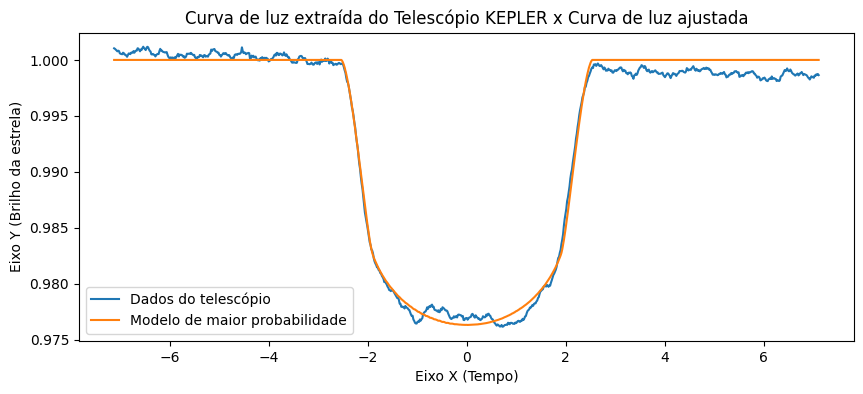

In [28]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajuste.eclipse_mcmc(time, theta_max)

plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()

plt.plot(time, flux, label = 'Dados do telescópio')
plt.plot(time, best_fit_model, label='Modelo de maior probabilidade')
print('Theta max: ',theta_max)

plotLegendAdjust(plt, mission)

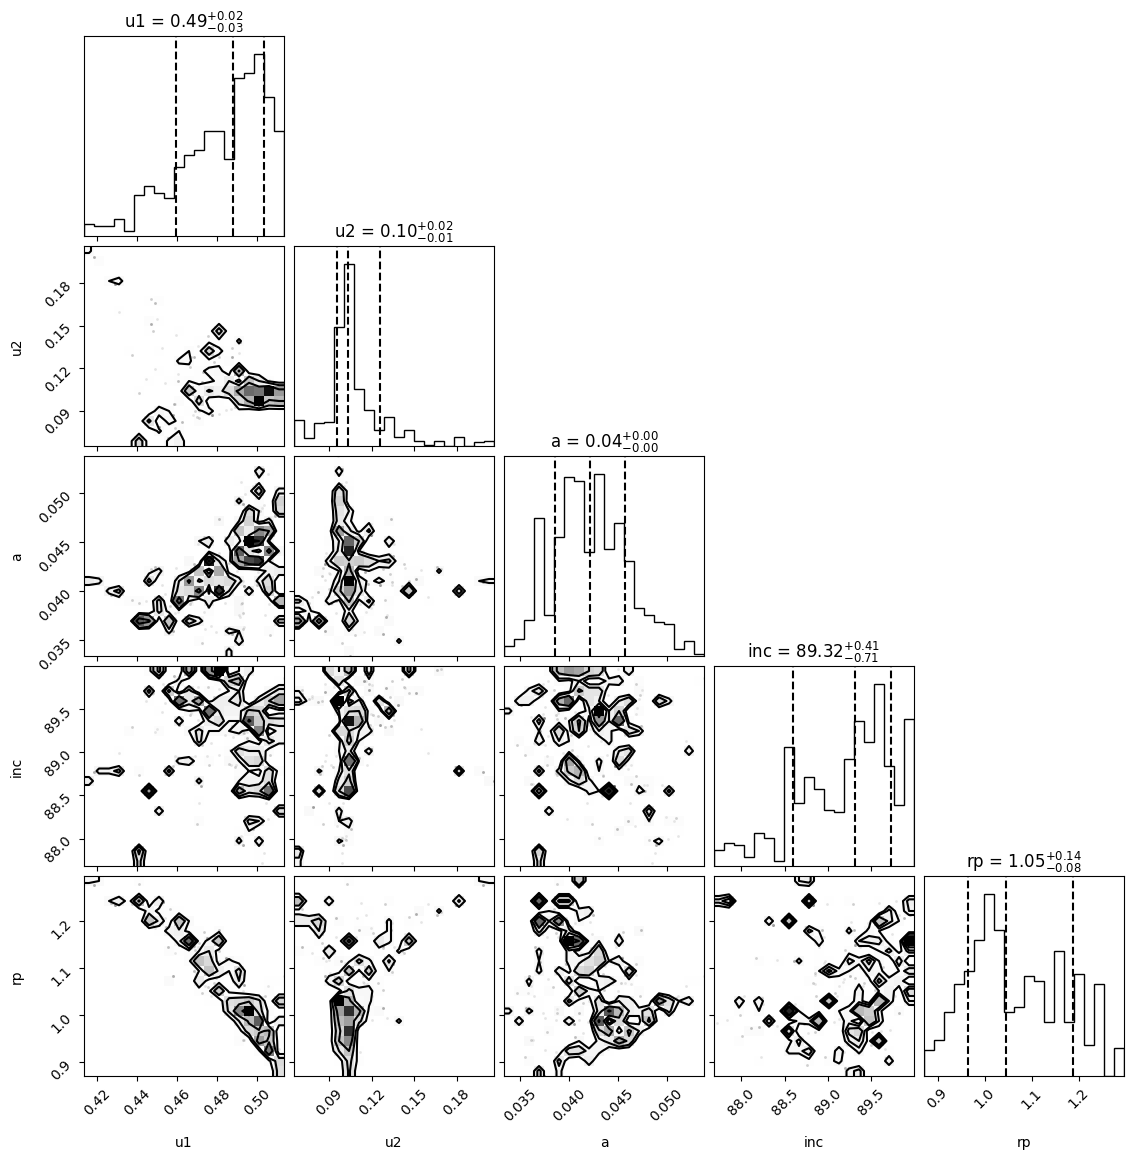

In [29]:
labels = ['u1','u2','a','inc','rp']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [30]:
results = []
for i, label in enumerate(labels):
    q_16, q_50, q_84 = numpy.percentile(samples[:, i], [16, 50, 84])
    print(f"{label}: {q_50:.3f} (+{q_84 - q_50:.3f} / -{q_50 - q_16:.3f})")
    results.append(q_50+(q_84 - q_50))

print(results)

u1: 0.488 (+0.016 / -0.028)
u2: 0.103 (+0.023 / -0.008)
a: 0.042 (+0.004 / -0.004)
inc: 89.317 (+0.415 / -0.714)
rp: 1.045 (+0.143 / -0.081)
[0.5037565426983858, 0.1258876742501756, 0.04579051943269844, 89.73192597291353, 1.1885533521277798]


# 🎯 MCMC Manchado
_Ajustes realizados para a aplicação do algoritmo MCMC em uma Estrela manchada.

In [ ]:
results = [0.4876834160643441, 0.1082646099893523, 0.04011797773536661, 88.02694810702533, 1.179830450228242]

In [ ]:
# Parâmetros resultados no primeiro mcmc (Sem manchas)
u1 = results[0]
u2 = results[1]
semi_eixo_UA = results[2]
angulo_inclinacao = results[3]
raio_plan_Jup = results[4]

estrela_ = Estrela(373, rsun, 240., u1, u2, 856)

Nx = estrela_.getNx()
Ny = estrela_.getNy()
raioEstrelaPixel = estrela_.getRaioStar()

planeta_= Planeta(semi_eixo_UA, raio_plan_Jup, periodo, angulo_inclinacao, ecc, anomalia, estrela_.getRaioSun(), mass_planeta)

eclipse = Eclipse(Nx, Ny, raioEstrelaPixel, estrela_, planeta_)
eclipse.setTempoHoras(1.)

In [ ]:
latsugerida = eclipse.calculaLatMancha()
longsugerida = eclipse.calculaLongMancha(semi_eixo_UA, 1.15, latsugerida)

A latitude sugerida para que a mancha influencie na curva de luz da estrela é: -17.86183566815458
A longitude sugerida para que a mancha influencie na curva de luz da estrela é: 0.27029496750332876


In [ ]:
raio_mancha = 0.07
intensidade = 0.5 
latitude = latsugerida
longitude = 15

mancha = Estrela.Mancha(intensidade, raio_mancha, latitude, longitude)

0.1037588119506836


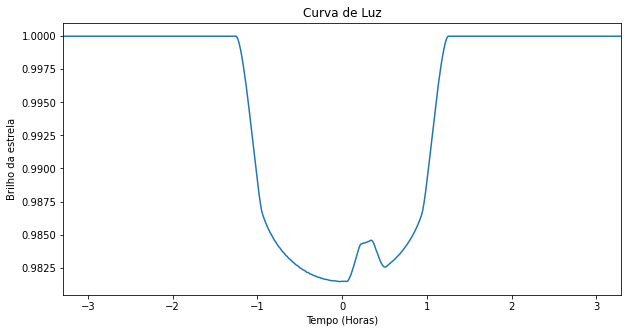

In [ ]:
estrela_.addMancha(mancha)
estrela_.criaEstrelaManchada()

estrela_matriz = estrela_.getMatrizEstrela()
eclipse.setEstrela(estrela_matriz)

eclipse.setTempoHoras(1)
eclipse.criarEclipse(anim = False)

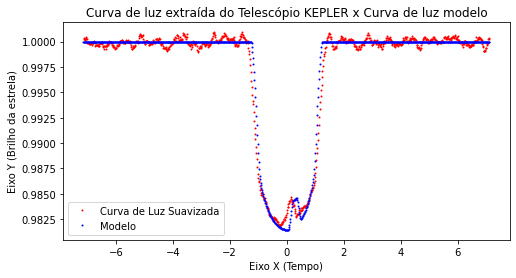

In [ ]:
# COM ESCOLHA DE TRÂNSITO
selectedTransit = 2 #transito selecionado
time_phased, smoothed_LC = tratamento.select_transit_smooth(selectedTransit)

plt.rcParams['figure.figsize']= 8, 4
graf1,ax = plt.subplots()


ax.plot(time_phased, smoothed_LC, "r.", ms=2, label='Curva de Luz Suavizada')
ax.plot(ts_model, eclipse.getCurvaLuz(), "b.", ms=2, label='Modelo')

plotLegendModel(ax, mission)

### Latitude das manchas 
Para que a mancha estejá alinhada à orbita do planeta, é necessária que a latitude desta esteja dentro da trajetória da órbita do planeta. Dessa forma, a seguir, sugerimos, com base no angulo de inclinação do planeta e seu semi-eixo, a latitude indicada para a plotagem das manchas. 

In [ ]:
nwalkers = 50
niter = 50
burnin = 30
ndim = 1

ajusteManchado = AjusteManchado(tratamento, time_phased, smoothed_LC, nwalkers, niter, burnin, ndim, eclipse,  rsun, periodo)

time = time_phased
flux = smoothed_LC

In [ ]:
sampler, pos, prob, state = ajusteManchado.main()

Running burn-in...


100%|██████████| 30/30 [06:45<00:00, 13.53s/it]


Running production...


100%|██████████| 50/50 [11:25<00:00, 13.71s/it]


In [ ]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([  7.1337633 , -17.34553196,   0.09544358,   0.6970613 ])

In [ ]:
theta_max  = samples[numpy.argmax(sampler.flatlnprobability)]
print(theta_max)
best_fit_model = ajusteManchado.eclipse_mcmc(time, theta_max)

[  7.1337633  -17.34553196   0.09544358   0.6970613 ]


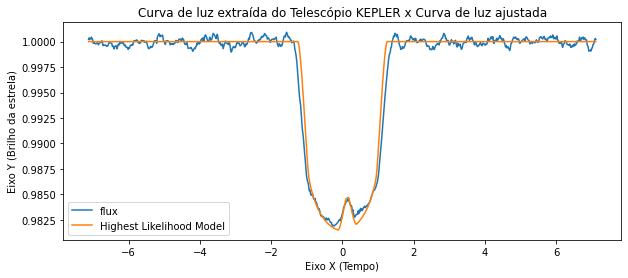

Theta max:  [  7.1337633  -17.34553196   0.09544358   0.6970613 ]


In [ ]:
### Plotagem de resultados #### 
plt.rcParams['figure.figsize']= 10, 4
graf1,ax = plt.subplots()
plt.plot(time, flux, label = 'flux')
plt.plot(time, best_fit_model, label='Highest Likelihood Model')
plotLegendAdjust(plt, mission)

print('Theta max: ',theta_max)

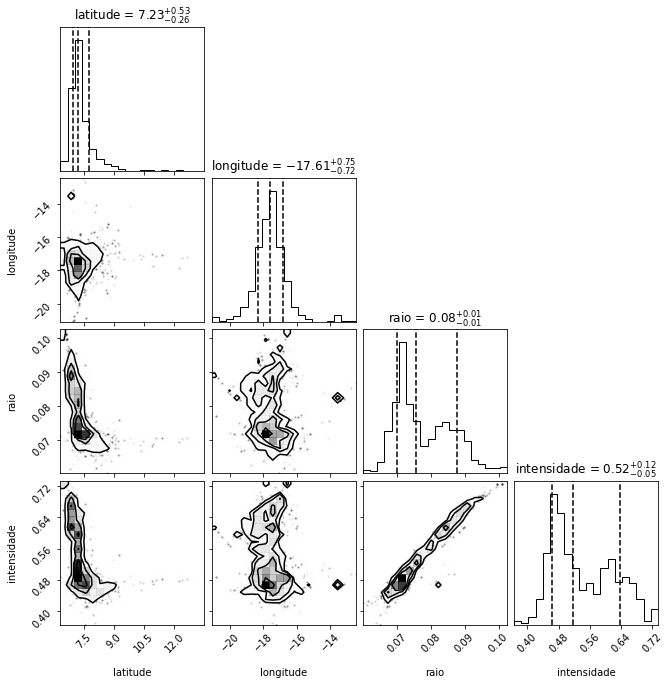

In [ ]:
labels = ['longitude','latitude','raio','intensidade']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])